# 叠加图

本节组合前面三节内容，介绍如何使用 cedarkit-maps 绘制 500 hPa 位势高度 + 850 hPa 风速叠加图。

首先导入需要使用的包。包括：

- 数据结构：numpy, pandas
- cedarkit 工具套件
    - 数据准备：reki
        - 数据查找函数： `find_local_file`
        - GRIB2文件要素加载函数：`load_field_from_file`
    - 气象可视化：cedarkit.maps
        - 绘图板：`Panel`
        - 底图布局：`EastAsiaMapDomain`
        - 绘图样式：`ContourStyle`, `ContourLabelStyle`, `BarbStyle`
        - 颜色表加载函数：`get_ncl_colormap`

In [1]:
import numpy as np
import pandas as pd

from reki.data_finder import find_local_file
from reki.format.grib.eccodes import load_field_from_file

from cedarkit.maps.style import ContourStyle, ContourLabelStyle, BarbStyle
from cedarkit.maps.chart import Panel
from cedarkit.maps.domains import EastAsiaMapTemplate
from cedarkit.maps.colormap import get_ncl_colormap

设置绘图的数据参数，使用 CMA-GFS 2024 年 11 月 14 日 00 时次 024 数据。

In [3]:
system_name = "CMA-GFS"
data_type = "cma_gfs_gmf/grib2/orig"
start_time = pd.to_datetime("2024-11-14 00:00:00")
forecast_time = pd.to_timedelta("24h")

## 加载数据

获取 GRIB2 数据路径

In [4]:
file_path = find_local_file(
    data_type,
    start_time=start_time,
    forecast_time=forecast_time,
)
file_path

PosixPath('/g3/COMMONDATA/OPER/CEMC/GFS_GMF/Prod-grib/2024111400/ORIG/gmf.gra.2024111400024.grb2')

加载 500 hPa 位势高度场。位势高度在 ecCodes 的内置要素名为 `gh`

In [5]:
h_500_field = load_field_from_file(
    file_path,
    parameter="gh",
    level_type="pl",
    level=500
) / 10.0
h_500_field

<xarray.DataArray 'gh' (latitude: 1440, longitude: 2880)> Size: 33MB
array([[527.97007813, 527.97007813, 527.97007813, ..., 527.97007813,
        527.97007813, 527.97007813],
       [527.90007813, 527.90007813, 527.90007813, ..., 527.90007813,
        527.90007813, 527.90007813],
       [527.82007813, 527.82007813, 527.82007813, ..., 527.82007813,
        527.82007813, 527.82007813],
       ...,
       [484.42007813, 484.42007813, 484.42007813, ..., 484.42007813,
        484.42007813, 484.42007813],
       [484.41007813, 484.41007813, 484.41007813, ..., 484.41007813,
        484.41007813, 484.41007813],
       [484.39007813, 484.39007813, 484.39007813, ..., 484.39007813,
        484.39007813, 484.39007813]])
Coordinates:
    time        datetime64[ns] 8B ...
    step        timedelta64[ns] 8B 1 days
    valid_time  datetime64[ns] 8B ...
    pl          float64 8B 500.0
  * latitude    (latitude) float64 12kB 89.94 89.81 89.69 ... -89.81 -89.94
  * longitude   (longitude) float64 23kB 0.0 0.125 0.25 ... 359.6 359.8 359.9

加载 850 hPa 风场。风场在 ecCodes 的内置要素名为 `u` 和 `v`

In [6]:
u_850_field = load_field_from_file(
    file_path,
    parameter="u",
    level_type="pl",
    level=850
)
v_850_field = load_field_from_file(
    file_path,
    parameter="v",
    level_type="pl",
    level=850
)
u_850_field

<xarray.DataArray 'u' (latitude: 1440, longitude: 2880)> Size: 33MB
array([[-3.42031738, -3.42031738, -3.42031738, ..., -3.42031738,
        -3.42031738, -3.42031738],
       [-1.61031738, -1.61031738, -1.61031738, ..., -1.61031738,
        -1.61031738, -1.61031738],
       [-1.77031738, -1.77031738, -1.77031738, ..., -1.77031738,
        -1.77031738, -1.77031738],
       ...,
       [-2.60031738, -2.59031738, -2.58031738, ..., -2.63031738,
        -2.62031738, -2.61031738],
       [-2.63031738, -2.62031738, -2.62031738, ..., -2.69031738,
        -2.67031738, -2.65031738],
       [-2.77031738, -2.79031738, -2.81031738, ..., -2.86031738,
        -2.85031738, -2.81031738]])
Coordinates:
    time        datetime64[ns] 8B ...
    step        timedelta64[ns] 8B 1 days
    valid_time  datetime64[ns] 8B ...
    pl          float64 8B 850.0
  * latitude    (latitude) float64 12kB 89.94 89.81 89.69 ... -89.81 -89.94
  * longitude   (longitude) float64 23kB 0.0 0.125 0.25 ... 359.6 359.8 359.9
Attributes: (12/17)
    GRIB_edition:             2
    GRIB_centre:              babj
    GRIB_subCentre:           0
    GRIB_tablesVersion:       4
    GRIB_localTablesVersion:  0
    GRIB_dataType:            fc
    ...                       ...
    GRIB_stepType:            instant
    GRIB_stepUnits:           1
    GRIB_stepRange:           24
    GRIB_endStep:int:         24
    GRIB_count:               149
    long_name:                discipline=0 parmcat=2 parm=2

计算得到风速场

In [7]:
wind_speed_850_field = np.sqrt(u_850_field ** 2 + v_850_field ** 2)
wind_speed_850_field

<xarray.DataArray (latitude: 1440, longitude: 2880)> Size: 33MB
array([[3.49408509, 3.49408509, 3.49408509, ..., 3.49005204, 3.49205483,
        3.49205483],
       [1.74963728, 1.74963728, 1.75357187, ..., 1.7457511 , 1.74963728,
        1.74963728],
       [1.82519138, 1.82519138, 1.82519138, ..., 1.82519138, 1.82519138,
        1.82519138],
       ...,
       [5.98069046, 6.03950877, 6.03522657, ..., 6.05677237, 6.03441402,
        6.03007846],
       [5.77019667, 5.91757894, 5.90861441, ..., 5.98460945, 5.95776006,
        5.94882276],
       [4.65091124, 4.75143846, 4.75514078, ..., 4.80894422, 4.80300303,
        4.77937368]])
Coordinates:
    time        datetime64[ns] 8B ...
    step        timedelta64[ns] 8B 1 days
    valid_time  datetime64[ns] 8B ...
    pl          float64 8B 850.0
  * latitude    (latitude) float64 12kB 89.94 89.81 89.69 ... -89.81 -89.94
  * longitude   (longitude) float64 23kB 0.0 0.125 0.25 ... 359.6 359.8 359.9

## 配置

为 500 hPa 位势高度场定义等值线样式

In [8]:
h_contour_lev = np.linspace(500, 588, endpoint=True, num=23)
h_contour_colos = "blue"
h_linewidths = np.where(h_contour_lev == 588, 1.4, 0.7)
hgt_style = ContourStyle(
    levels=h_contour_lev,
    colors="blue",
    linewidths=h_linewidths,
    label=True,
    label_style=ContourLabelStyle(
        colors="black",
        fontsize=8,
    )
)

为 850 hPa 风速定义填充图样式

In [9]:
wind_speed_contour_lev = np.arange(8, 26, 2)

color_index = np.arange(90, 236, 15) - 2
color_index[0] = -1
wind_speed_color_map = get_ncl_colormap(
    "rainbow+white+gray", index=color_index
)

wind_speed_style = ContourStyle(
    colors=wind_speed_color_map,
    levels=wind_speed_contour_lev,
    fill=True,
)

为 850 hPa 风场定义风场图样式

In [10]:
wind_barb_style = BarbStyle(
    barbcolor="red",
    flagcolor="red",
    linewidth=0.3,
)

## 绘制

创建中国区域底图布局

In [11]:
domain = EastAsiaMapTemplate()

绘制叠加图，设置标题和颜色条。

多次调用 `Panel.plot()` 方法实现图形的叠加绘制。

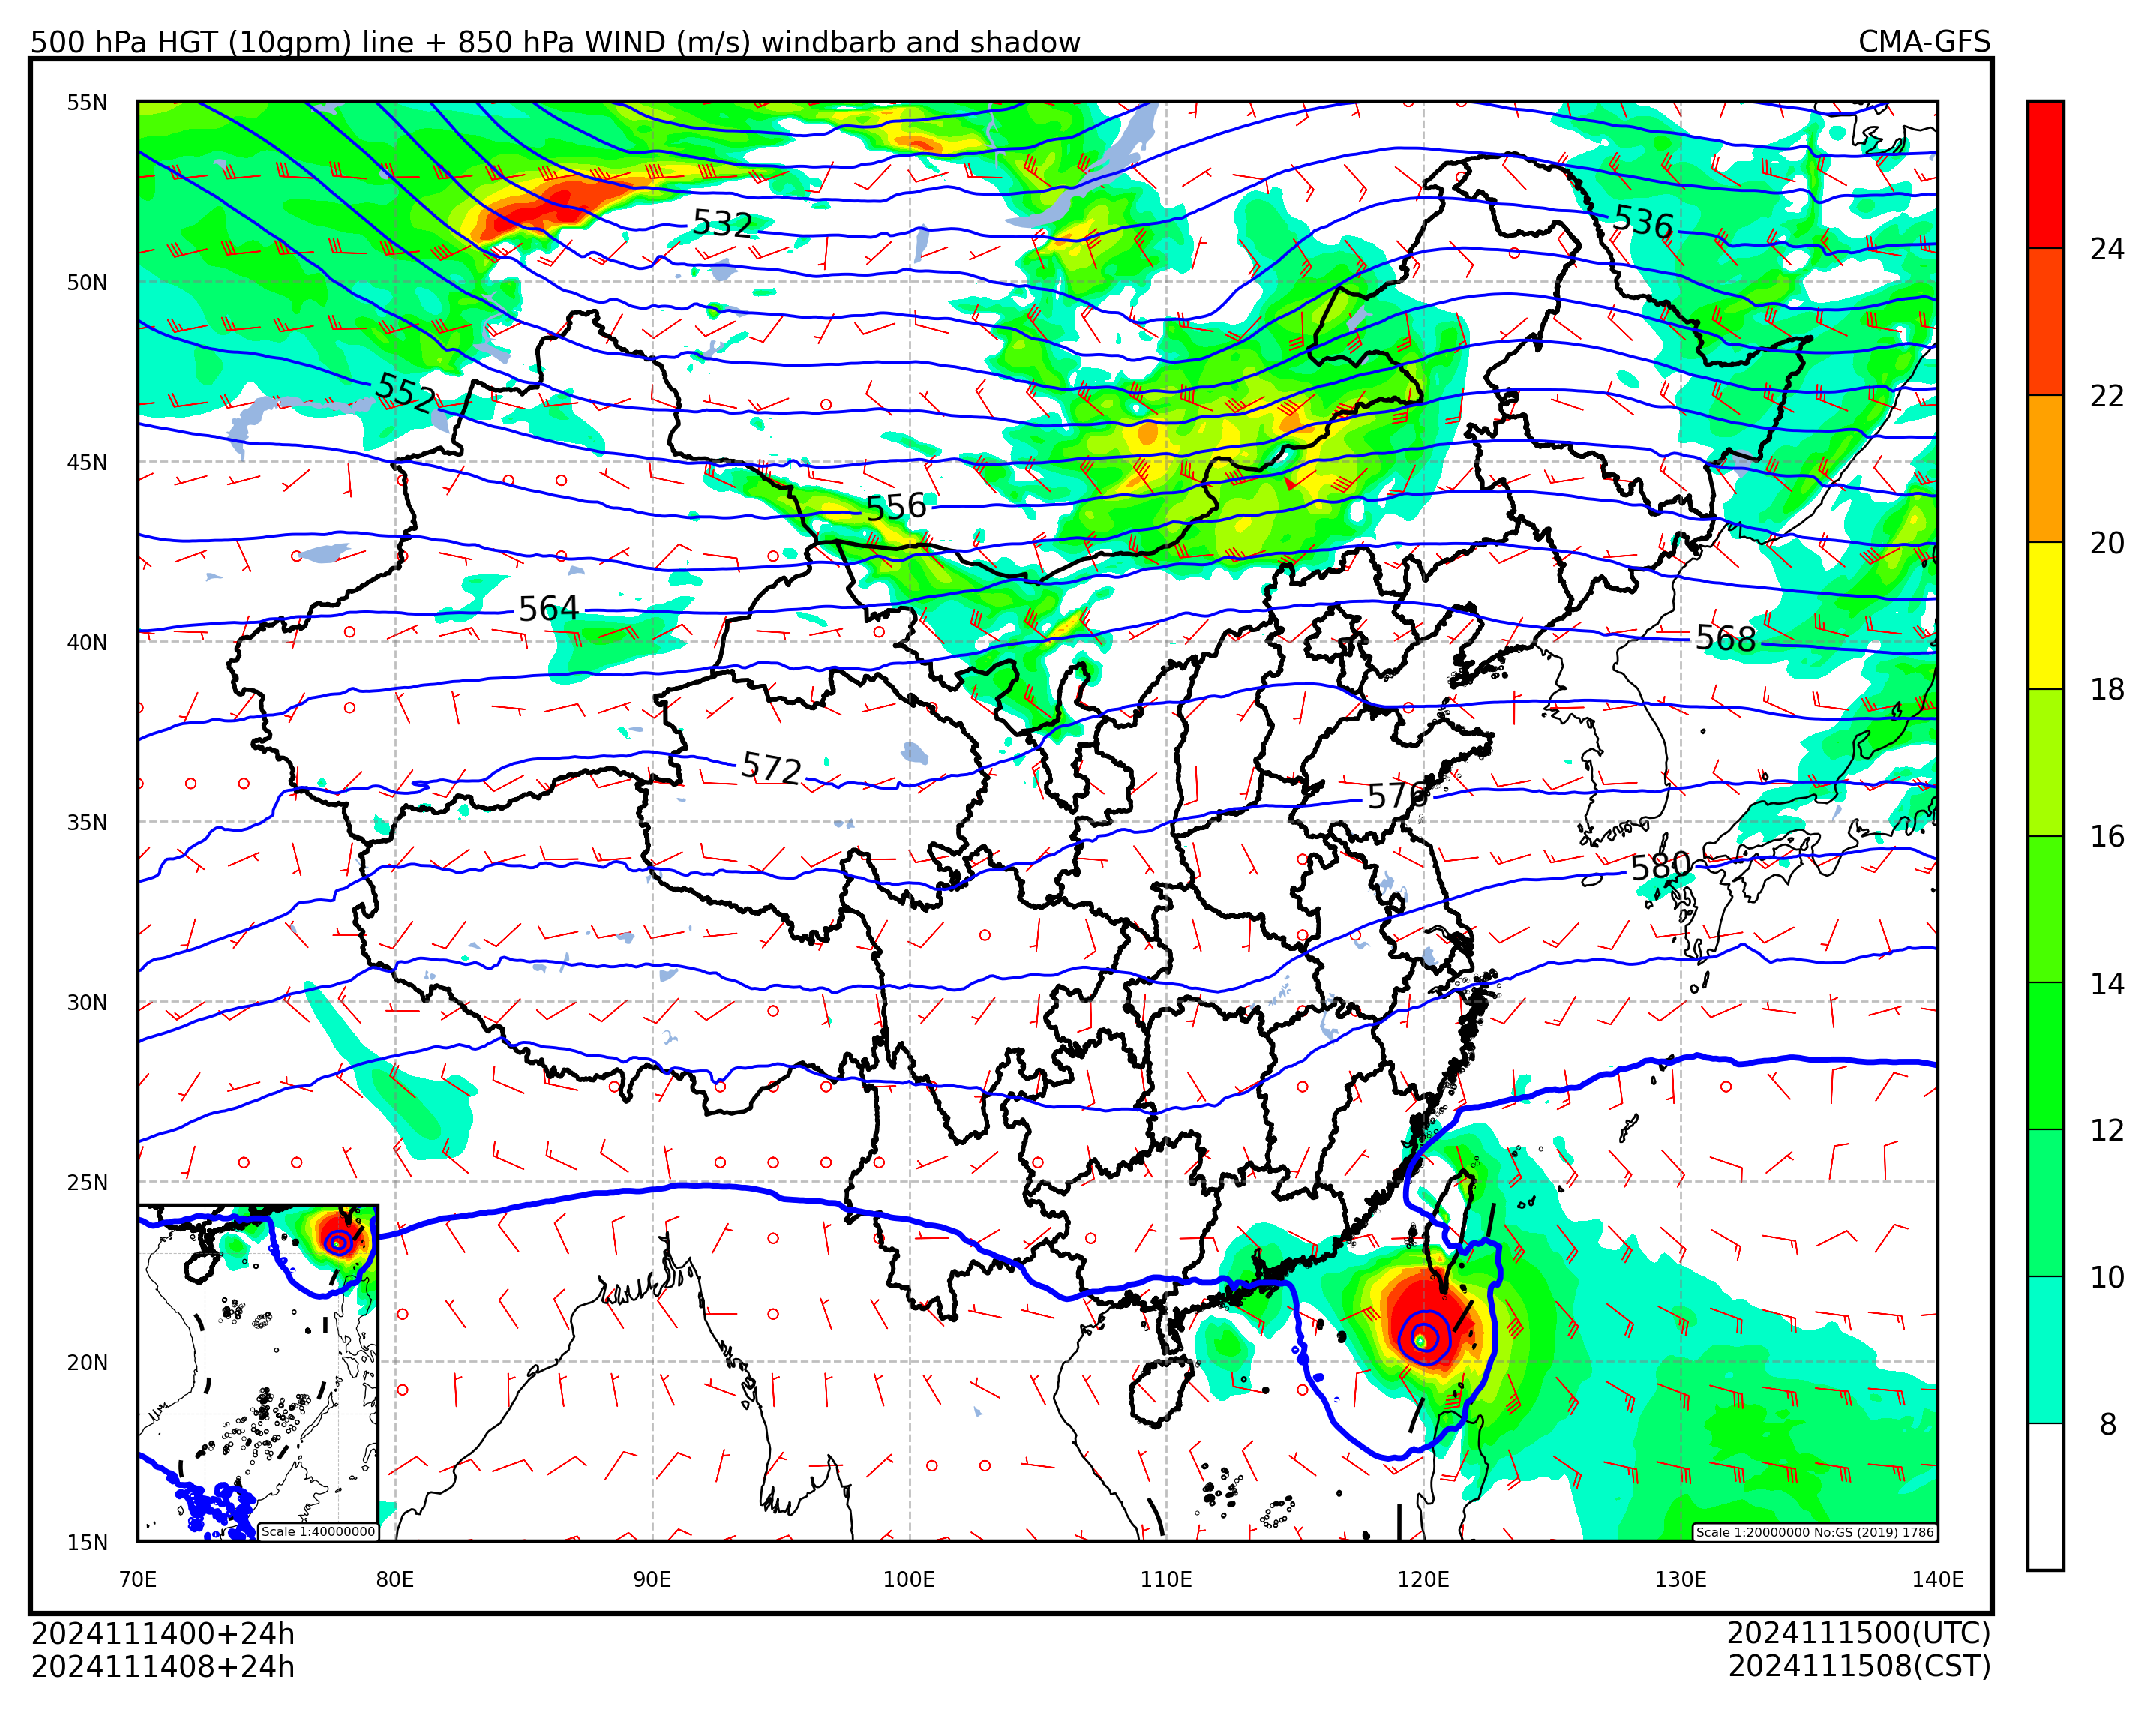

In [12]:
panel = Panel(domain=domain)
panel.plot(h_500_field, style=hgt_style)
panel.plot(wind_speed_850_field, style=wind_speed_style)
panel.plot([[u_850_field[::14, ::14], v_850_field[::14, ::14]]], style=wind_barb_style, layer=[0])

domain.set_title(
    panel=panel,
    graph_name="500 hPa HGT (10gpm) line + 850 hPa WIND (m/s) windbarb and shadow",
    system_name=system_name,
    start_time=start_time,
    forecast_time=forecast_time,
)
domain.add_colorbar(panel=panel, style=wind_speed_style)
panel.show()